In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.price_history_21_seq2seq_dyn_dec_ins import PriceHistorySeq2SeqDynDecIns

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 50
with_EOS = False

In [5]:
total_train_size = 57994
train_size = 6400 
test_size = 1282

# Global Scale Normalization

### Once generate data

In [6]:
data_path = '../data/price_history'

In [7]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'
npz_full_train = data_path + '/price_history_03_dp_60to30_global_remove_scale_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
#npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'
npz_train = data_path + '/price_history_03_dp_60to30_6400_global_remove_scale_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
#npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'
npz_test = data_path + '/price_history_03_dp_60to30_global_remove_scale_test.npz'

In [8]:
#%%time
# csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'

# train_sku_ids, train_XX, train_YY, train_sequence_lens, train_seq_mask, test_pack = \
#     PriceHistoryDatasetGenerator(random_state=random_state).createAndSaveDataset(
#             csv_in=csv_in,
#             input_seq_len=input_len,
#             target_seq_len=target_len,
#             allowSmallerSequencesThanWindow=False,
#             #min_date = '2016-11-01',
#             split_fraction = 0.40,
#             #keep_training_fraction = 0.22, #57994 * 0.22 = 12758.68
#             normalize_targets = False,
#             do_global_norm_scale = True,
#             #disable saving for now since we have already created them
#             save_files_dic = {"train": npz_full_train, "test": npz_test,},
#     )

In [9]:
# print train_sku_ids.shape, train_XX.shape, train_YY.shape, train_sequence_lens.shape, train_seq_mask.shape
# aa,bb,cc,dd,ee = test_pack.get_data()
# aa.shape,bb.shape,cc.shape,dd.shape,ee.shape

In [10]:
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_trainfull_train,
#                                                target_size = train_size,
#                                                outpath = npz_train, random_state=random_state)

### Step 1 - collect data

In [11]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [12]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [13]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [14]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

In [15]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [16]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=20,
             batch_size = 50,
             num_units = 400,
             input_len=input_len,
             target_len=target_len,
             #learning_rate = 0.0026945952539362472,
             preds_gather_enabled=True,
             batch_norm_enabled = True,
             activation = tf.nn.elu,
             decoder_first_input = PriceHistorySeq2SeqDynDecIns.DECODER_FIRST_INPUT.PREVIOUS_INPUT,
             #keep_prob_input = 0.9,
             #lamda2 = 1e-2,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [17]:
%%time
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='022_seq2seq_60to30_001')

CPU times: user 704 ms, sys: 0 ns, total: 704 ms
Wall time: 700 ms


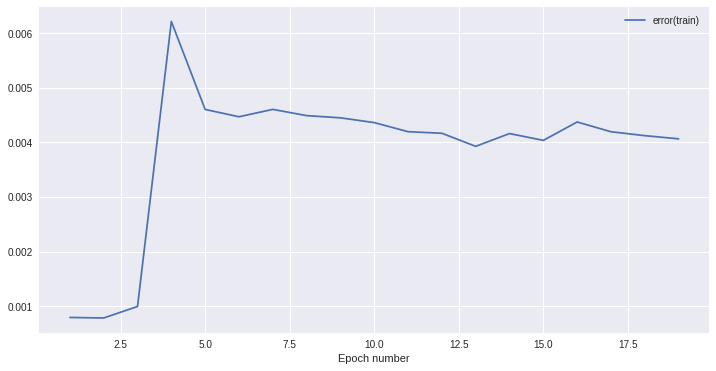

In [18]:
dyn_stats.plotStats()
plt.show()

In [19]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [20]:
ind = np.argmin(r2_scores)
ind

2569

In [21]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [22]:
r2_score(y_true=reals, y_pred=preds)

-1.4199962056347357e+32

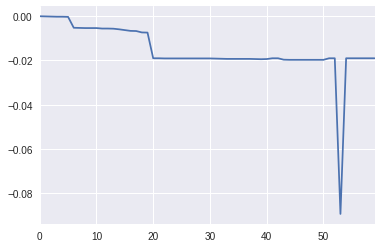

In [23]:
sns.tsplot(data=dp.inputs[ind].flatten())

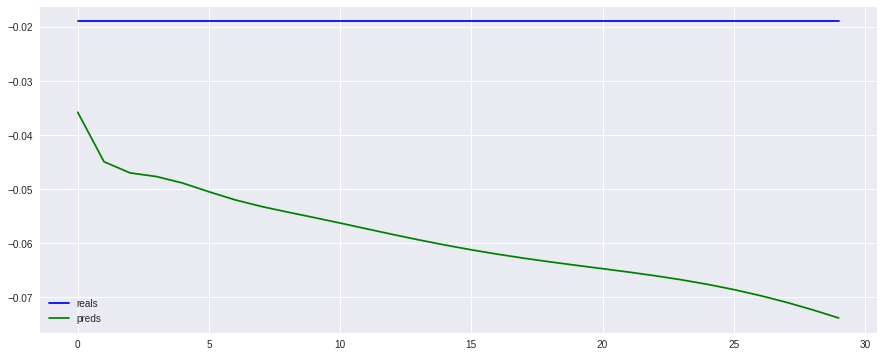

In [24]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [25]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13 s, sys: 100 ms, total: 13.1 s
Wall time: 13 s


In [27]:
aa = fastdtw(dp.targets[0], preds_dict[0])

In [33]:
import fastdtw as fst
targets = dp.targets[0]
preds = preds_dict[0]
ind = 0

In [35]:
print type(targets)
print type(targets[ind])
print targets.shape
print type(preds)
print type(preds[ind])
print preds.shape

<type 'numpy.ndarray'>
<type 'numpy.float64'>
(30,)
<type 'numpy.ndarray'>
<type 'numpy.float64'>
(30,)


In [26]:
np.mean(dtw_scores)

2.103477780808928

In [27]:
coint(preds, reals)

(-0.40984010460311138,
 0.97016523699800961,
 array([-4.31395736, -3.55493606, -3.19393252]))

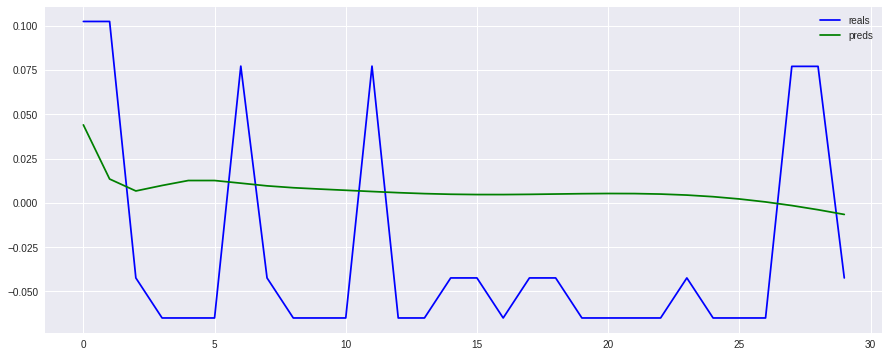

In [54]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???

# Global Scale Normalization plus normalization per instance

### Once generate data

In [6]:
data_path = '../data/price_history'

In [7]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'
npz_full_train = data_path + '/price_history_03_dp_60to30_global_local_remove_scale_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
#npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'
npz_train = data_path + '/price_history_03_dp_60to30_6400_global_local_remove_scale_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
#npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'
npz_test = data_path + '/price_history_03_dp_60to30_global_local_remove_scale_test.npz'

In [8]:
#%%time
# csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'

# train_sku_ids, train_XX, train_YY, train_sequence_lens, train_seq_mask, test_pack = \
#     PriceHistoryDatasetGenerator(random_state=random_state).createAndSaveDataset(
#             csv_in=csv_in,
#             input_seq_len=input_len,
#             target_seq_len=target_len,
#             allowSmallerSequencesThanWindow=False,
#             #min_date = '2016-11-01',
#             split_fraction = 0.40,
#             #keep_training_fraction = 0.22, #57994 * 0.22 = 12758.68
#             normalize_targets = False,
#             do_global_norm_scale = True,
#             norm_instance_scale = True,
#             #disable saving for now since we have already created them
#             save_files_dic = {"train": npz_full_train, "test": npz_test,},
#     )

In [9]:
# print train_sku_ids.shape, train_XX.shape, train_YY.shape, train_sequence_lens.shape, train_seq_mask.shape
# aa,bb,cc,dd,ee = test_pack.get_data()
# aa.shape,bb.shape,cc.shape,dd.shape,ee.shape

(57994,) (57994, 60, 1) (57994, 30) (57994,) (57994, 60)


((1282,), (1282, 60, 1), (1282, 30), (1282,), (1282, 60))

In [11]:
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_full_train,
#                                                target_size = train_size,
#                                                outpath = npz_train, random_state=random_state)

### Step 1 - collect data

In [12]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [13]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [14]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [15]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

In [16]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [17]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=20,
             batch_size = 50,
             num_units = 400,
             input_len=input_len,
             target_len=target_len,
             #learning_rate = 0.0026945952539362472,
             preds_gather_enabled=True,
             batch_norm_enabled = True,
             activation = tf.nn.elu,
             decoder_first_input = PriceHistorySeq2SeqDynDecIns.DECODER_FIRST_INPUT.PREVIOUS_INPUT,
             #keep_prob_input = 0.9,
             #lamda2 = 1e-2,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [18]:
%%time
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='022_seq2seq_60to30_002')

epochs: 20
learning_rate: 0.001
keep_prob_input: 1.0
End Epoch 01 (32.886 secs): err(train) = 0.074512
current dec_ins_percent_usage: 1.0
End Epoch 02 (31.881 secs): err(train) = 0.056361
current dec_ins_percent_usage: 0.75
End Epoch 03 (32.316 secs): err(train) = 0.050933
current dec_ins_percent_usage: 0.5
End Epoch 04 (31.666 secs): err(train) = 0.067669
current dec_ins_percent_usage: 0.25
End Epoch 05 (31.630 secs): err(train) = 0.316446
current dec_ins_percent_usage: 0.0
End Epoch 06 (31.573 secs): err(train) = 0.240851
current dec_ins_percent_usage: 0.0
End Epoch 07 (31.606 secs): err(train) = 0.236075
current dec_ins_percent_usage: 0.0
End Epoch 08 (31.580 secs): err(train) = 0.224232
current dec_ins_percent_usage: 0.0
End Epoch 09 (31.602 secs): err(train) = 0.225593
current dec_ins_percent_usage: 0.0
End Epoch 10 (31.577 secs): err(train) = 0.221800
current dec_ins_percent_usage: 0.0
End Epoch 11 (31.592 secs): err(train) = 0.220316
current dec_ins_percent_usage: 0.0
End Epoch 

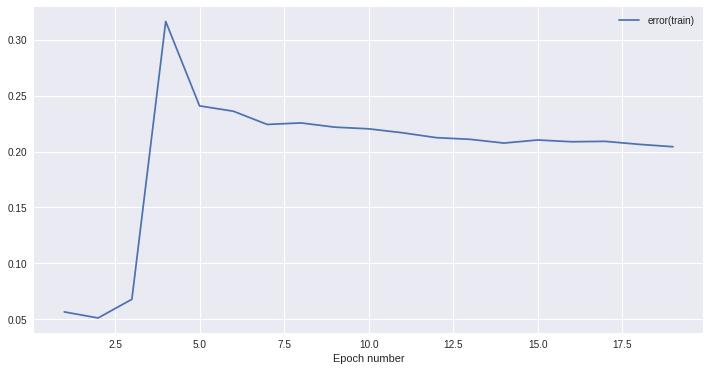

In [19]:
dyn_stats.plotStats()
plt.show()

In [20]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [21]:
ind = np.argmin(r2_scores)
ind

5860

In [22]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [23]:
r2_score(y_true=reals, y_pred=preds)

-1.0348669019461579e+31

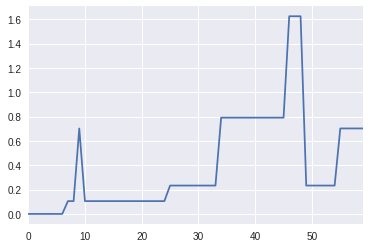

In [24]:
sns.tsplot(data=dp.inputs[ind].flatten())

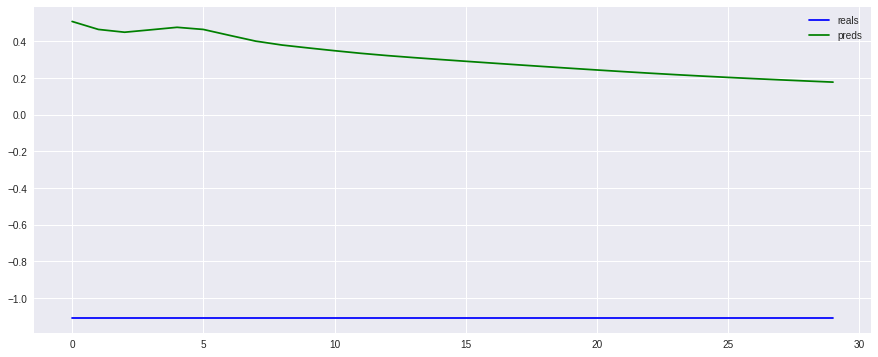

In [25]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [26]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13.5 s, sys: 88 ms, total: 13.6 s
Wall time: 13.4 s


In [27]:
np.mean(dtw_scores)

12.693255650923957

In [28]:
coint(preds, reals)

(7.555547687587393, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

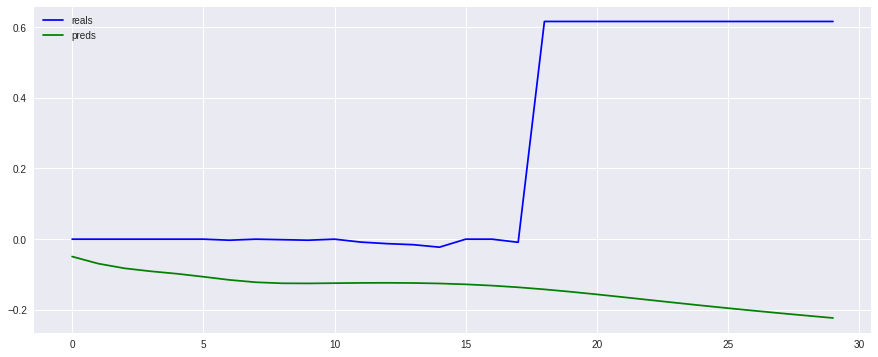

In [29]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
Local Scaling didn't help! We will use only global scaling

# Global Scale Normalization plus with normalized targets

### Once generate data

In [9]:
data_path = '../data/price_history'

In [10]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'
npz_full_train = data_path + '/price_history_03_dp_60to30_global_remove_scale_targets_normed_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
#npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'
npz_train = data_path + '/price_history_03_dp_60to30_6400_global_remove_scale_targets_normed_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
#npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'
npz_test = data_path + '/price_history_03_dp_60to30_global_remove_scale_targets_normed_test.npz'

In [11]:
#%%time
csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'

train_sku_ids, train_XX, train_YY, train_sequence_lens, train_seq_mask, test_pack = \
    PriceHistoryDatasetGenerator(random_state=random_state).createAndSaveDataset(
            csv_in=csv_in,
            input_seq_len=input_len,
            target_seq_len=target_len,
            allowSmallerSequencesThanWindow=False,
            #min_date = '2016-11-01',
            split_fraction = 0.40,
            #keep_training_fraction = 0.22, #57994 * 0.22 = 12758.68
            normalize_targets = True,
            do_global_norm_scale = True,
            norm_instance_scale = False,
            #disable saving for now since we have already created them
            save_files_dic = {"train": npz_full_train, "test": npz_test,},
    )

In [12]:
print train_sku_ids.shape, train_XX.shape, train_YY.shape, train_sequence_lens.shape, train_seq_mask.shape
aa,bb,cc,dd,ee = test_pack.get_data()
aa.shape,bb.shape,cc.shape,dd.shape,ee.shape

(57994,) (57994, 60, 1) (57994, 30) (57994,) (57994, 60)


((1282,), (1282, 60, 1), (1282, 30), (1282,), (1282, 60))

In [13]:
PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_full_train,
                                               target_size = train_size,
                                               outpath = npz_train, random_state=random_state)

### Step 1 - collect data

In [14]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [15]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [16]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [17]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

In [18]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [19]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=20,
             batch_size = 50,
             num_units = 400,
             input_len=input_len,
             target_len=target_len,
             #learning_rate = 0.0026945952539362472,
             preds_gather_enabled=True,
             batch_norm_enabled = True,
             activation = tf.nn.elu,
             decoder_first_input = PriceHistorySeq2SeqDynDecIns.DECODER_FIRST_INPUT.ZEROS,
             #keep_prob_input = 0.9,
             #lamda2 = 1e-2,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [32]:
%%time
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='022_seq2seq_60to30_003')

epochs: 20
learning_rate: 0.001
keep_prob_input: 1.0
End Epoch 01 (32.824 secs): err(train) = 0.000948
current dec_ins_percent_usage: 1.0
End Epoch 02 (31.627 secs): err(train) = 0.000671
current dec_ins_percent_usage: 0.75
End Epoch 03 (31.602 secs): err(train) = 0.000678
current dec_ins_percent_usage: 0.5
End Epoch 04 (31.638 secs): err(train) = 0.000791
current dec_ins_percent_usage: 0.25
End Epoch 05 (31.657 secs): err(train) = 0.003951
current dec_ins_percent_usage: 0.0
End Epoch 06 (31.715 secs): err(train) = 0.003404
current dec_ins_percent_usage: 0.0
End Epoch 07 (31.621 secs): err(train) = 0.003395
current dec_ins_percent_usage: 0.0
End Epoch 08 (31.632 secs): err(train) = 0.003381
current dec_ins_percent_usage: 0.0
End Epoch 09 (31.668 secs): err(train) = 0.003372
current dec_ins_percent_usage: 0.0
End Epoch 10 (31.632 secs): err(train) = 0.003384
current dec_ins_percent_usage: 0.0
End Epoch 11 (31.654 secs): err(train) = 0.003378
current dec_ins_percent_usage: 0.0
End Epoch 

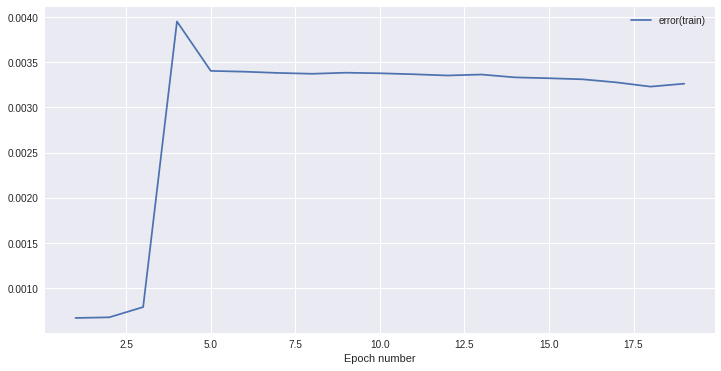

In [33]:
dyn_stats.plotStats()
plt.show()

In [34]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [35]:
ind = np.argmin(r2_scores)
ind

4621

In [36]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [37]:
r2_score(y_true=reals, y_pred=preds)

-1.7316564499006635e+31

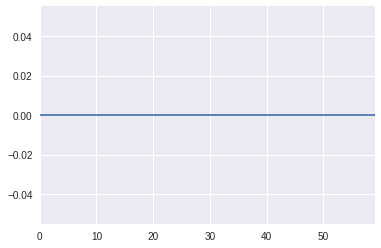

In [38]:
sns.tsplot(data=dp.inputs[ind].flatten())

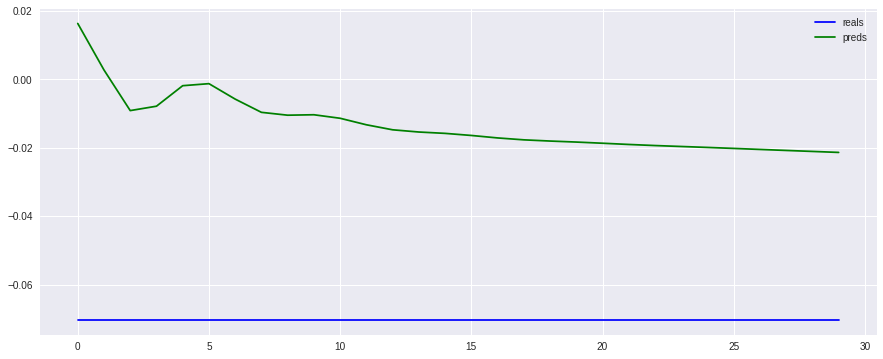

In [39]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [40]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13.3 s, sys: 76 ms, total: 13.4 s
Wall time: 13.2 s


In [41]:
np.mean(dtw_scores)

1.2217091336270045

In [42]:
coint(preds, reals)

(1.1907827807061317, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

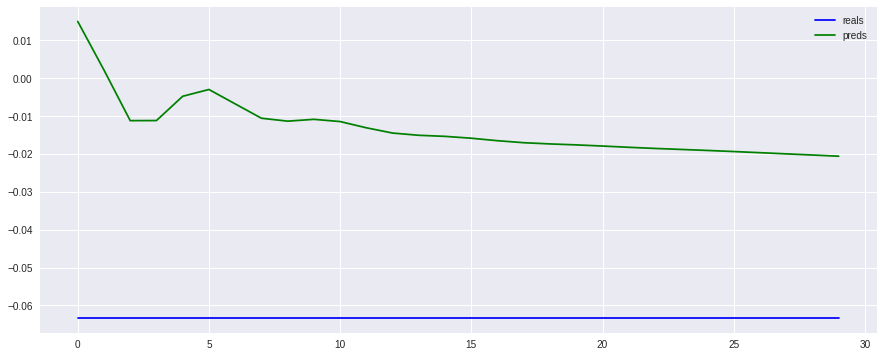

In [55]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [68]:
aa =  zip(np.arange(10), np.arange(10)*-1)
aa

[(0, 0),
 (1, -1),
 (2, -2),
 (3, -3),
 (4, -4),
 (5, -5),
 (6, -6),
 (7, -7),
 (8, -8),
 (9, -9)]